In [1]:
import LinearAlgebra
using Plots
using Random

using JuMP

import MathOptInterface
const MOI = MathOptInterface

using MosekTools

## Problem 8

In [2]:
# generate anchor locations
a1 = [1; 0]
a2 = [-1; 0]
a3 = [0; 2]

A = [a1 a2 a3]
n, m = size(A)


Random.seed!(222)
x_true = (rand(n,1) .- 0.5).*3 # randomly generate sensor locations

2×1 Array{Float64,2}:
 -0.4033351560494658
 -0.19047626404886375

In [3]:
function get_d(A, x) # get distances
    n, m = size(A)

    d = Array{Float64}(undef, m)
    for i in 1:m
        d[i] = LinearAlgebra.norm(A[:,i] .- x)
    end
    return d
end

d = get_d(A, x_true)

3-element Array{Float64,1}:
 1.4162029400373348
 0.6263306979324323
 2.2273000497164532

In [4]:
function check_cvxhull(A, x) # check whether x is in the convex hull of columns of A
    n, m = size(A)
    model = Model(Mosek.Optimizer)
    set_silent(model)
    @variable(model, lbd[1:m] >= 0)
    @constraint(model, sum(lbd) == 1)
    
    @constraint(model, A * lbd .== x)
    optimize!(model)
    if primal_status(model) == MOI.FEASIBLE_POINT
        return true
    else 
        return false
    end
end

flag_in = check_cvxhull(A, x_true)
println("$(x_true) is in the convex hull: $(flag_in)")

[-0.4033351560494658; -0.19047626404886375] is in the convex hull: false


In [5]:

function socp_loc(A,d) # obtain solution by SOCP relaxation
    socp = Model(Mosek.Optimizer)
    set_silent(socp)
    @variable(socp, x[1:n])
    for i in 1:m
        @constraint(socp, [d[i]; A[:,i] .- x] in SecondOrderCone())
    end
    optimize!(socp)

    #@show objective_value(socp)
    x_sol = value.(x)
    #@show x_sol
    return x_sol
end

x_socp = socp_loc(A,d)
println("SOCP solution is $(x_socp)")

SOCP solution is [-0.39282852407579405, 0.0519964804643502]


In [6]:
x_true = [0;1] 
d = get_d(A, x_true)
flag_in = check_cvxhull(A, x_true)
println("$(x_true) is in the convex hull: $(flag_in)")
x_socp = socp_loc(A,d)
println("SOCP solution is $(x_socp)")

[0, 1] is in the convex hull: true
SOCP solution is [1.2878287325435167e-10, 1.0000000000057856]


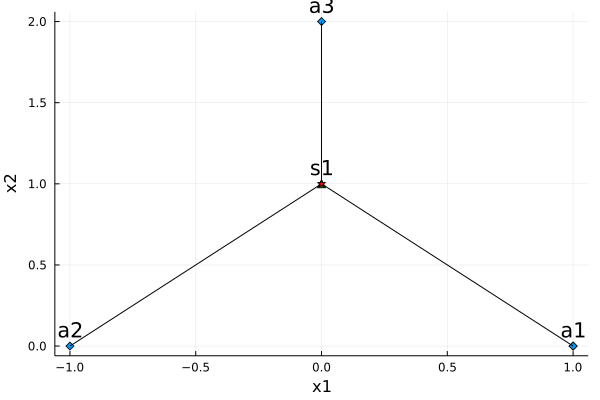

In [7]:

flag_in = check_cvxhull(A, x_true)
gr() # We will continue onward using the GR backend

function plt_loc(A, x; kwargs...)
    
    
    fig = plot( [A[1,:]; A[1,1]], [A[2,:]; A[2,1]], seriestype=:scatter, markershape=:diamond, legend = false)
    annotate!.(A[1,:], A[2,:].+0.1, ["a1", "a2", "a3"])
    
    # true location is denoted by triangle
    plot!([x[1,:]], [x[2,:]], seriestype=:scatter, color=:green, markershape=:utriangle, legend = false)
    for i in 1:3
        plot!([x[1,1]; A[1,i]], [x[2,1]; A[2,i]], color=:black, legend = false )
    end

    annotate!.(x[1,:], x[2,:].+0.1, [join(["s", string(i)]) for i in 1:size(x,2)])
    
    kwargs_dict = Dict(kwargs)
    if haskey(kwargs_dict, :x_sol) # solution
        x_sol = kwargs_dict[:x_sol]
        plot!([x_sol[1,:]], [x_sol[2,:]], seriestype=:scatter, color=:red, markershape=:star, legend = false)
    end

    xlabel!("x1")
    ylabel!("x2")
    display(fig)
    sleep(1)
end

plt_loc(A,x_true,x_sol=x_socp)


### Problem 8(a)

In [8]:
# try a few locations
inside = zeros(2)
outside = zeros(2)
error_tol = 1e-6
for i in 1:100
    
    x_true = (rand(n,1) .- 0.5).*3
    d = get_d(A, x_true)
    flag_in = check_cvxhull(A, x_true)
    x_socp = socp_loc(A,d)
    error = LinearAlgebra.norm(x_true - x_socp)/(1+LinearAlgebra.norm(x_true))
    if flag_in == true
        inside[1] += 1
        if error < error_tol
            inside[2] += 1
        end
    else
        outside[1] += 1
        if error < error_tol
            outside[2] += 1
        end
    end
end 

# if inside the convex hull, then SOCP recovers exactly, otherwise cannot
println("If the sensor location is inside the convex hull, then SOCP recovers $(inside[2])/$(inside[1])")
println("If the sensor location is outside the convex hull, then SOCP recovers $(outside[2])/$(outside[1])")

If the sensor location is inside the convex hull, then SOCP recovers 17.0/17.0
If the sensor location is outside the convex hull, then SOCP recovers 0.0/83.0


In [9]:

function sdp_loc(A,d) # obtain solution by SDP relaxation
    
    sdp = Model(Mosek.Optimizer)
    set_silent(sdp)
    @variable(sdp, x[1:n])
    @variable(sdp, Y[1:1,1:1])
    @constraint(sdp, [LinearAlgebra.I x; x' Y] in PSDCone() )
    for i in 1:3
        temp = [A[:,i]; -1]

        @constraint(sdp, sum((temp*temp').* [LinearAlgebra.I x; x' Y]) == d[i]^2)
    end
    optimize!(sdp)

    #@show objective_value(sdp)
    #@show value.(x)
    x_sol = value.(x)
    #@show x_sol
    return x_sol
end


sdp_loc (generic function with 1 method)

### Problem 8(b)

In [10]:
# try a few locations
inside = zeros(2)
outside = zeros(2)

for i in 1:100
    
    x_true = (rand(n,1) .- 0.5).*3
    d = get_d(A, x_true)
    flag_in = check_cvxhull(A, x_true)
    x_sdp = sdp_loc(A,d)
    error = LinearAlgebra.norm(x_true - x_sdp)/(1+LinearAlgebra.norm(x_true))
    if flag_in == true
        inside[1] += 1
        if error < error_tol
            inside[2] += 1
        end
    else
        outside[1] += 1
        if error < error_tol
            outside[2] += 1
        end
    end
end 

# SDP always recovers the true location
println("If the sensor location is inside the convex hull, then SDP recovers $(inside[2])/$(inside[1])")
println("If the sensor location is outside the convex hull, then SDP recovers $(outside[2])/$(outside[1])")

If the sensor location is inside the convex hull, then SDP recovers 21.0/21.0
If the sensor location is outside the convex hull, then SDP recovers 79.0/79.0


## Problem 9

In [11]:
Random.seed!(222)

X_true = (rand(n,2) .- 0.5).*3

function get_d9(A,X)

    d = Array{Float64}(undef, 5)
    
    d[1] = LinearAlgebra.norm(A[:,1] .- X[:,1])
    d[2] = LinearAlgebra.norm(A[:,2] .- X[:,1])
    d[3] = LinearAlgebra.norm(A[:,2] .- X[:,2])
    d[4] = LinearAlgebra.norm(A[:,3] .- X[:,2])
    d[5] = LinearAlgebra.norm(X[:,1] .- X[:,2])
    
    return d
end

d = get_d9(A,X_true)

5-element Array{Float64,1}:
 1.4162029400373348
 0.6263306979324323
 1.7433751477623782
 2.1005362504263303
 1.168369142634505

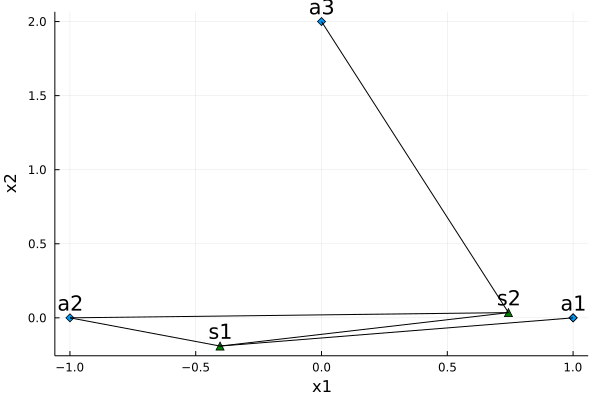

In [12]:
function plt_loc9(A, x; kwargs...)

    fig = plot( [A[1,:]; A[1,1]], [A[2,:]; A[2,1]], seriestype=:scatter, markershape=:diamond, legend = false)
    annotate!.(A[1,:], A[2,:].+0.1, ["a1", "a2", "a3"])
    
    plot!([x[1,:]], [x[2,:]], seriestype=:scatter, color=:green, markershape=:utriangle, legend = false)
    
    plot!([x[1,1]; A[1,1]], [x[2,1]; A[2,1]], color=:black, legend = false)
    plot!([x[1,1]; A[1,2]], [x[2,1]; A[2,2]], color=:black, legend = false )
    
    plot!([x[1,2]; A[1,2]], [x[2,2]; A[2,2]], color=:black, legend = false )
    plot!([x[1,2]; A[1,3]], [x[2,2]; A[2,3]], color=:black, legend = false )
    
    plot!(x[1,:], x[2,:],  color=:black, legend = false )
    
    annotate!.(x[1,:], x[2,:].+0.1, [join(["s", string(i)]) for i in 1:size(x,2)])
    
    kwargs_dict = Dict(kwargs)
    if haskey(kwargs_dict, :x_sol) # solution
        x_sol = kwargs_dict[:x_sol]
        plot!([x_sol[1,:]], [x_sol[2,:]], seriestype=:scatter, color=:red, markershape=:star, legend = false)
    end

    xlabel!("x1")
    ylabel!("x2")
    display(fig)
    sleep(1)
end

plt_loc9(A, X_true)

In [13]:

function socp_loc9(A,d)
    socp = Model(Mosek.Optimizer)
    set_silent(socp)
    @variable(socp, X[1:n,1:2])
    
    @constraint(socp, [d[1]; A[:,1] .- X[:,1]] in SecondOrderCone())
    @constraint(socp, [d[2]; A[:,2] .- X[:,1]] in SecondOrderCone())
    @constraint(socp, [d[3]; A[:,2] .- X[:,2]] in SecondOrderCone())
    @constraint(socp, [d[4]; A[:,3] .- X[:,2]] in SecondOrderCone())
    @constraint(socp, [d[5]; X[:,1] .- X[:,2]] in SecondOrderCone())

    optimize!(socp)

    #@show objective_value(socp)
    X_sol = value.(X)

    return X_sol
end

socp_loc9 (generic function with 1 method)

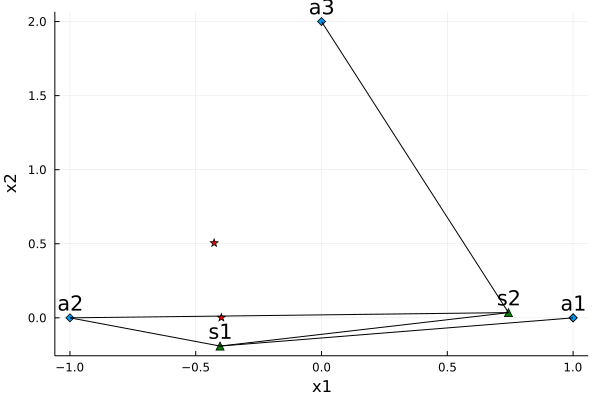

In [14]:
X_socp = socp_loc9(A,d)
plt_loc9(A, X_true, x_sol=X_socp)

In [15]:
# we check whether sensor locations are inside the convex hull when SOCP recovers the locations
for i in 1:1000
    
    X_true = (rand(n,2) .- 0.5).*2
    flag_in = [check_cvxhull(A, X_true[:,1]), check_cvxhull(A, X_true[:,2])]
    
    d = get_d9(A,X_true)
    X_socp = socp_loc9(A,d)
    error = LinearAlgebra.norm(X_true - X_socp)/(1+LinearAlgebra.norm(X_true))
    if error < error_tol
        println(flag_in)
    end
end 

Bool[1, 1]
Bool[1, 1]
Bool[1, 1]
Bool[1, 1]
Bool[1, 1]
Bool[1, 1]
Bool[1, 1]
Bool[1, 1]
Bool[1, 1]
Bool[1, 1]
Bool[1, 1]
Bool[1, 1]
Bool[1, 1]
Bool[1, 1]
Bool[1, 1]


In [16]:

inside = zeros(2)

for i in 1:100
    
    X_true = (rand(n,2) .- 0.5).*2
    flag_in = [check_cvxhull(A, X_true[:,1]), check_cvxhull(A, X_true[:,2])]
    
    d = get_d9(A,X_true)
    X_socp = socp_loc9(A,d)
    if flag_in == [true, true]
        error = LinearAlgebra.norm(x_true - x_socp)/(1+LinearAlgebra.norm(x_true))
 
        inside[1] += 1
        if error < error_tol
            inside[2] += 1
        end

    end
end 

println("If both sensor locations are inside the convex hull, then SOCP recovers $(inside[2])/$(inside[1])")
# even if both are in the convex hull, SOCP may not recover exactly

If both sensor locations are inside the convex hull, then SOCP recovers 0.0/19.0


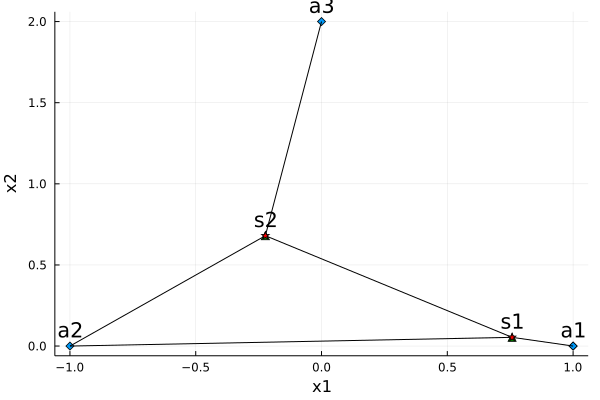

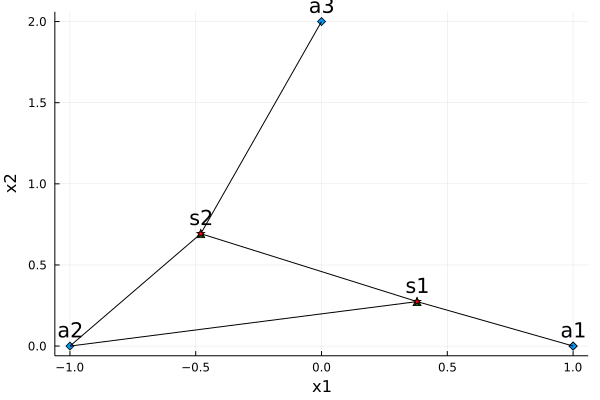

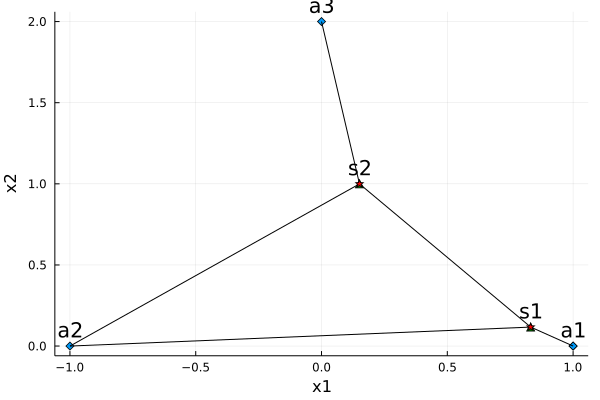

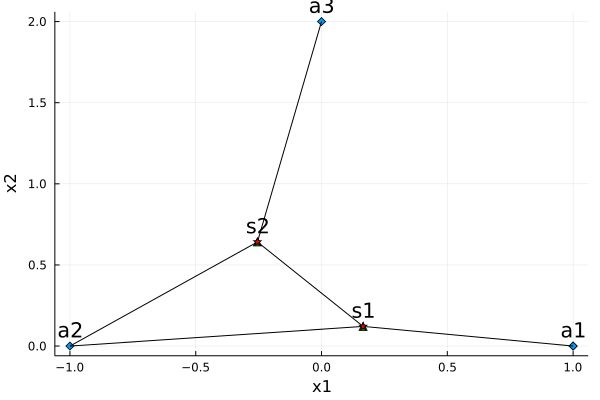

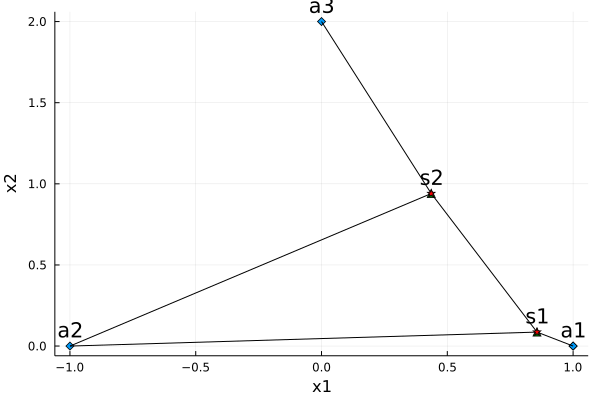

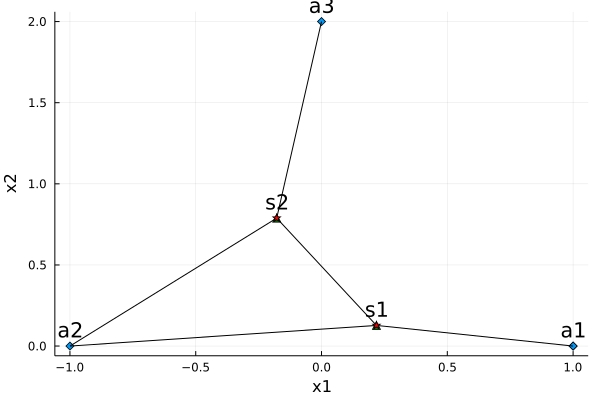

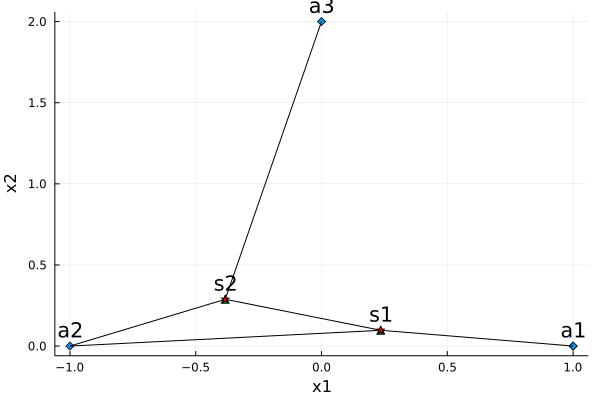

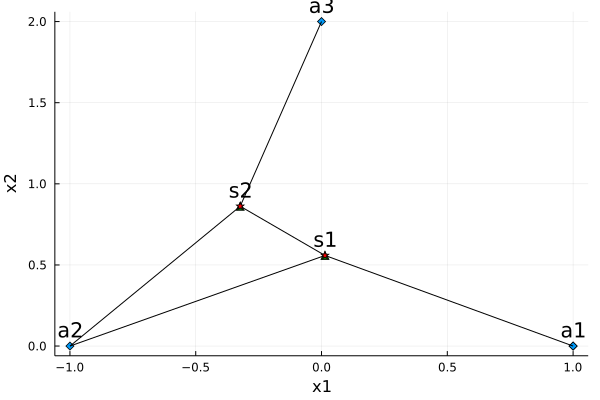

In [17]:
for i in 1:500
    
    X_true = (rand(n,2) .- 0.5).*2
    flag_in = [check_cvxhull(A, X_true[:,1]), check_cvxhull(A, X_true[:,2])]
    
    d = get_d9(A,X_true)
    X_socp = socp_loc9(A,d)
    error = LinearAlgebra.norm(X_true - X_socp)/(1+LinearAlgebra.norm(X_true))
    if error < error_tol
        
        plt_loc9(A,X_true,x_sol=X_socp)
   
    end
end 

# for the problem instances where SOCP recovers the solution, 
# s1 in in the convex hull of s2,a1,a2
# s2 is in the convex hull of s1,a2,a3

In [18]:

function sdp_loc9(A,d)
    sdp = Model(Mosek.Optimizer)
    set_silent(sdp)
    @variable(sdp, X[1:n,1:2])
    @variable(sdp, Y[1:2,1:2])
    @variable(sdp, Z[1:n+2, 1:n+2], PSD)
    @constraint(sdp, Z .== [LinearAlgebra.I X; X' Y] )
    

    @constraint(sdp, sum(([A[:,1]; -1; 0]*[A[:,1]; -1; 0]').* Z) == d[1]^2 )
    @constraint(sdp, sum(([A[:,2]; -1; 0]*[A[:,2]; -1; 0]').* Z) == d[2]^2 )
    
    @constraint(sdp, sum(([A[:,2]; 0; -1]*[A[:,2]; 0; -1]').* Z) == d[3]^2 )
    @constraint(sdp, sum(([A[:,3]; 0; -1]*[A[:,3]; 0; -1]').* Z) == d[4]^2 )
    
    @constraint(sdp, sum(([0;0; 1; -1]*[0;0; 1; -1]').* Z) == d[5]^2 )
    
    optimize!(sdp)

    #@show objective_value(socp)
    X_sol = value.(X)

    return X_sol
end

sdp_loc9 (generic function with 1 method)

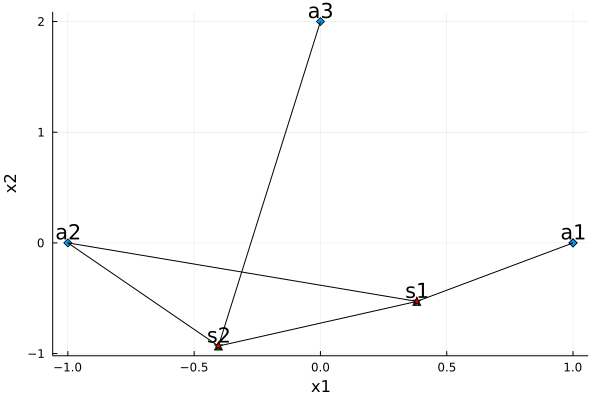

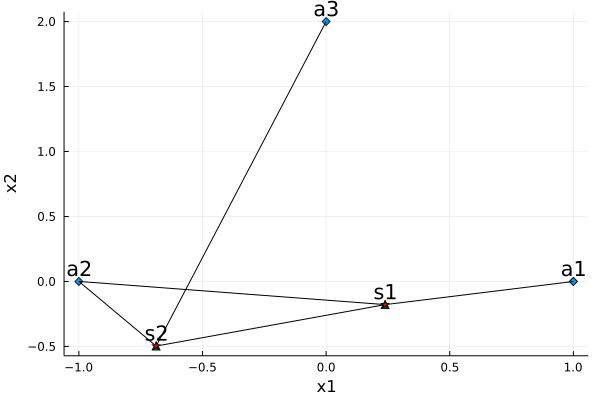

In [19]:
for i in 1:10
    
    X_true = (rand(n,2) .- 0.5).*2
    flag_in = [check_cvxhull(A, X_true[:,1]), check_cvxhull(A, X_true[:,2])]
    
    d = get_d9(A,X_true)
    X_sdp = sdp_loc9(A,d)
    error = LinearAlgebra.norm(X_true - X_sdp)/(1+LinearAlgebra.norm(X_true))
    if error < error_tol
        
        plt_loc9(A,X_true,x_sol=X_sdp)
   
    end
end 

# SDP is better at recovering the exact solution than SOCP relaxtion, but it is difficult to see the recovering 
# condition. However, we can analyze the rank of the dual solution. 

## Problem 10

In [20]:
mdp = Model(Mosek.Optimizer)
set_silent(mdp)
γ = 0.9 

@variable(mdp, v[0:5])

@constraint(mdp, red0, v[0] <= γ* v[1])
@constraint(mdp, blue0, v[0] <= γ* ([0.5;0.25;0.125;0.125]'* v[2:5]) )

@constraint(mdp, red1, v[1] <= γ* v[2])
@constraint(mdp, blue1, v[1] <= γ* ([0.5;0.25;0.25]'* v[3:5]) )

@constraint(mdp, red2, v[2] <= γ* v[3])
@constraint(mdp, blue2, v[2] <= γ* ([0.5;0.5]'* v[4:5]) )

@constraint(mdp, red3, v[3] <= γ* v[4])
@constraint(mdp, blue3, v[3] <= γ* ([0.5;0.5]'* v[4:5]) )

@constraint(mdp, black4, v[4] <= 1 + γ* v[5])

@constraint(mdp, black5, v[5] <= γ* v[0])

@objective(mdp, Max, sum(v))

optimize!(mdp)

v_sol = value.(v)
println(v_sol)

1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, 0:5
And data, a 6-element Array{Float64,1}:
 0.747207793464978
 0.8302308816277534
 0.9224787573641704
 1.0249763970713004
 1.605238312706632
 0.6724870141184801


In [21]:
println(value(red0), value(blue0)) # choose red at 0
println(value(red1), value(blue1)) # choose red at 1
println(value(red2), value(blue2)) # choose red at 2
println(value(red3), value(blue3)) # choose blue at 3


0.0-0.15477143595776632
0.0-0.1434966955899819
0.0-0.10249763970713
-0.41973808436466840.0
